# Pretrained Models for Transfer Learning
- If there's not enough training data, it is a good idea to use a pretrained model's lower layers
- example w/ Xception model pretrained on ImageNet:

In [1]:
import tensorflow_datasets as tfds

(train_set_raw, valid_set_raw, test_set_raw), info = tfds.load('tf_flowers', as_supervised=True, with_info=True, split=['train[:75%]', 'train[75%:90%]', 'train[90%:]'])
dataset_size = info.splits["train"].num_examples #3670
class_names = info.features["label"].names # ["dandelion", "daisies"]
n_classes = info.features["label"].num_classes #5

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


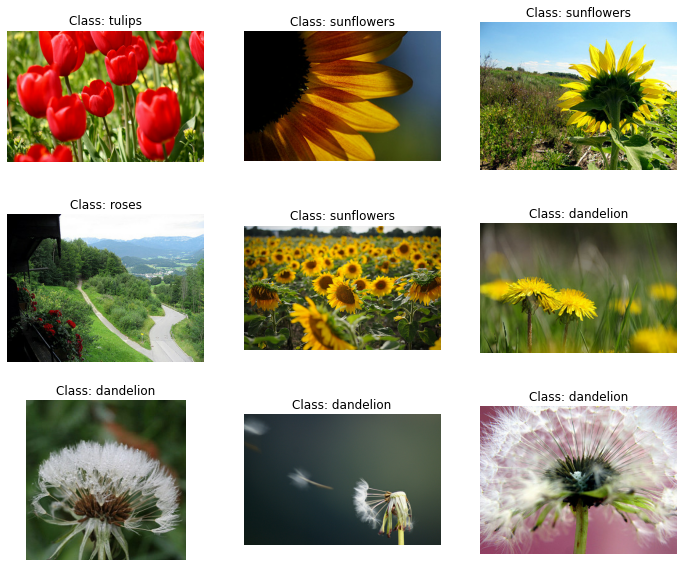

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [3]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [4]:
import tensorflow as tf
from tensorflow import keras

batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set_raw.map(preprocess).batch(batch_size).prefetch(1) #prefetching caches the data in fast memory (RAM) for faster fetching time
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [5]:
# load an Xception model pretrained on ImageNet

base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False) # exclude the top of the NN(global avg pooling layer and Dense layer)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output) # add own global avg pooling layer based on output of base model
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output) # uses base model's layers directly rather than the base_model itself

83689472/83683744 [==============================] - 0s 0us/step


In [6]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [7]:
# freeze the weights of the pretrained layers

for layer in base_model.layers:
    layer.trainable = False

In [8]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

86/86 [==============================] - 41s 106ms/step - loss: 2.4565 - accuracy: 0.6689 - val_loss: 0.5234 - val_accuracy: 0.9002
Epoch 2/5
86/86 [==============================] - 8s 90ms/step - loss: 0.5437 - accuracy: 0.9043 - val_loss: 0.4730 - val_accuracy: 0.8984
Epoch 3/5
86/86 [==============================] - 8s 90ms/step - loss: 0.2434 - accuracy: 0.9397 - val_loss: 0.4501 - val_accuracy: 0.8893
Epoch 4/5
86/86 [==============================] - 8s 90ms/step - loss: 0.1650 - accuracy: 0.9515 - val_loss: 0.5359 - val_accuracy: 0.8766
Epoch 5/5
86/86 [==============================] - 8s 90ms/step - loss: 0.1381 - accuracy: 0.9572 - val_loss: 0.4309 - val_accuracy: 0.8984


In [10]:
# unfreeze all layers because the top layers are now well-trained

for layer in base_model.layers:
  layer.trainable = True

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 38s 397ms/step - loss: 0.5023 - accuracy: 0.8415 - val_loss: 0.3440 - val_accuracy: 0.9111
Epoch 2/5
86/86 [==============================] - 34s 390ms/step - loss: 0.0405 - accuracy: 0.9872 - val_loss: 0.2694 - val_accuracy: 0.9238
Epoch 3/5
86/86 [==============================] - 33s 389ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2578 - val_accuracy: 0.9292
Epoch 4/5
86/86 [==============================] - 33s 389ms/step - loss: 8.2637e-04 - accuracy: 1.0000 - val_loss: 0.2636 - val_accuracy: 0.9310
Epoch 5/5
86/86 [==============================] - 34s 390ms/step - loss: 5.9386e-04 - accuracy: 1.0000 - val_loss: 0.2698 - val_accuracy: 0.9310


In [11]:
model.evaluate(test_set)

12/12 [==============================] - 1s 96ms/step - loss: 0.1779 - accuracy: 0.9455


[0.1779220998287201, 0.9455040693283081]